In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [56]:
import pandas as pd
import numpy as np
import nltk
stopwords = nltk.corpus.stopwords.words('english')

from wordcloud import WordCloud
from collections import Counter


import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from scipy.stats.stats import pearsonr

import swifter
import dask.dataframe as dd
from dask.multiprocessing import get

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
path2rawdata = '/mnt/disks/vault/wos2017-parsed/'
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')


In [129]:
title_pos_tagged_1981_1990 = "/mnt/disks/vault/analysis-data/stanford_tagger_data/pos_tagged_stanford_1980_1990.pql"
title_pos_tagged_1991_2000 = "/mnt/disks/vault/analysis-data/stanford_tagger_data/pos_tagged_stanford_1990_2000.pql"
title_pos_tagged_2001_2010 = "/mnt/disks/vault/analysis-data/stanford_tagger_data/pos_tagged_stanford_2001.pql"


data_81_90 = pd.read_pickle(title_pos_tagged_1981_1990)
data_91_00 = pd.read_pickle(title_pos_tagged_1991_2000)
data_01_10 = pd.read_pickle(title_pos_tagged_2001_2010)


data = pd.concat([data_81_90, 
                  data_91_00, 
                  data_01_10])

In [130]:
data.head()

,ArticleID,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,stanford_tagger_tags
0,A1981MB41800038,1981,Article,INDEPENDENT CONTROL OF IMMUNOGLOBULIN HEAVY AND LIGHT CHAIN EXPRESSION IN A MURINE PRE-B-CELL LINE,NATURE,Nature,1981,23.0,"[(INDEPENDENT, NNP), (CONTROL, NNP), (OF, IN), (IMMUNOGLOBULIN, NNP), (HEAVY, JJ), (AND, NNP), (LIGHT, NNP), (CHAIN, NNP), (EXPRESSION, NNP), (IN, IN), (A, NNP), (MURINE, NNP), (PRE-B-CELL, NNP), (LINE, NNP)]"
1,A1981MK47400052,1981,Article,DEMETHYLATION OF CPG SITES IN DNA OF EARLY RABBIT TROPHOBLAST,NATURE,Nature,1981,14.0,"[(DEMETHYLATION, NNS), (OF, IN), (CPG, NN), (SITES, NNS), (IN, IN), (DNA, NN), (OF, IN), (EARLY, FW), (RABBIT, FW), (TROPHOBLAST, NN)]"
5,000204440900038,1981,Article,Comb-layering in carbonatite dykes,NATURE,Nature,1981,5.0,"[(Comb-layering, JJ), (in, FW), (carbonatite, FW), (dykes, NNS)]"
8,A1981MT99400035,1981,Article,STRUCTURE SENSITIVITY IN THE IRON SINGLE-CRYSTAL CATALYZED SYNTHESIS OF AMMONIA,NATURE,Nature,1981,6.0,"[(STRUCTURE, NN), (SENSITIVITY, NN), (IN, IN), (THE, DT), (IRON, NNP), (SINGLE-CRYSTAL, NNP), (CATALYZED, NNP), (SYNTHESIS, NNP), (OF, IN), (AMMONIA, NNP)]"
9,A1981LS25500015,1981,Article,IR VARIABILITY OF SS433,NATURE,Nature,1981,4.0,"[(IR, NNP), (VARIABILITY, NNP), (OF, IN), (SS433, NN)]"


In [134]:
## What are the unique tags

all_tags_ = []

def all_tags(parts_tagged):
    tags = [tag for (word, tag) in parts_tagged]
    all_tags_.extend(tags)
    
data['stanford_tagger_tags'].progress_apply(lambda x: all_tags(x))
set(all_tags_)


Progress: 100%|██████████| 43632/43632 [00:00<00:00, 479106.83it/s]

{"''",
 '.',
 ':',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'SYM',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB'}

In [135]:
verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
noun_tags = ['NN','NNS','NNP','NNPS']
adjective_tags = ['JJ','JJR','JJS']
adverb_tags = ['RB', 'RBR', 'RBS', 'WRB']
determiner_tags = ['PDT','DT','WDT']
pronoun_tag = ['WP','PRP','PRP$']
symbol_tag = ['SYM']
conjunction_tags = ['CC','IN','UH']
other_tags = ['LS','MD','FW','EX',]

pos_tag_groups_to_check = [verb_tags, noun_tags, adjective_tags, 
                           adverb_tags, determiner_tags, pronoun_tag,
                           symbol_tag, conjunction_tags, other_tags]

In [136]:
#count of verbs, nouns and adjectives in the titles


def pos_counts(parts_tagged):
    tags = [tag for (word, tag) in parts_tagged]
    
    return [len([tag for tag in tags if tag in tag_group]) for tag_group in pos_tag_groups_to_check]


    
    
test_tags = [('FCA', 'NN'), ('does', 'VBZ'), ('not', 'RB'), ('bind', 'VB'), ('abscisic', 'JJ'), ('acid', 'NN'),
            ('Cyclical', 'JJ'), ('DNA', 'NN'), ('methylation', 'NN'), ('of', 'IN')]

In [138]:
data['tag_counts'] = data['stanford_tagger_tags'].progress_apply(lambda x: pos_counts(x))

data.head()


Progress: 100%|██████████| 43632/43632 [00:00<00:00, 90095.38it/s]

,ArticleID,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,stanford_tagger_tags,tag_counts
0,A1981MB41800038,1981,Article,INDEPENDENT CONTROL OF IMMUNOGLOBULIN HEAVY AND LIGHT CHAIN EXPRESSION IN A MURINE PRE-B-CELL LINE,NATURE,Nature,1981,23.0,"[(INDEPENDENT, NNP), (CONTROL, NNP), (OF, IN), (IMMUNOGLOBULIN, NNP), (HEAVY, JJ), (AND, NNP), (LIGHT, NNP), (CHAIN, NNP), (EXPRESSION, NNP), (IN, IN), (A, NNP), (MURINE, NNP), (PRE-B-CELL, NNP), (LINE, NNP)]","[0, 11, 1, 0, 0, 0, 0, 2, 0]"
1,A1981MK47400052,1981,Article,DEMETHYLATION OF CPG SITES IN DNA OF EARLY RABBIT TROPHOBLAST,NATURE,Nature,1981,14.0,"[(DEMETHYLATION, NNS), (OF, IN), (CPG, NN), (SITES, NNS), (IN, IN), (DNA, NN), (OF, IN), (EARLY, FW), (RABBIT, FW), (TROPHOBLAST, NN)]","[0, 5, 0, 0, 0, 0, 0, 3, 2]"
5,000204440900038,1981,Article,Comb-layering in carbonatite dykes,NATURE,Nature,1981,5.0,"[(Comb-layering, JJ), (in, FW), (carbonatite, FW), (dykes, NNS)]","[0, 1, 1, 0, 0, 0, 0, 0, 2]"
8,A1981MT99400035,1981,Article,STRUCTURE SENSITIVITY IN THE IRON SINGLE-CRYSTAL CATALYZED SYNTHESIS OF AMMONIA,NATURE,Nature,1981,6.0,"[(STRUCTURE, NN), (SENSITIVITY, NN), (IN, IN), (THE, DT), (IRON, NNP), (SINGLE-CRYSTAL, NNP), (CATALYZED, NNP), (SYNTHESIS, NNP), (OF, IN), (AMMONIA, NNP)]","[0, 7, 0, 0, 1, 0, 0, 2, 0]"
9,A1981LS25500015,1981,Article,IR VARIABILITY OF SS433,NATURE,Nature,1981,4.0,"[(IR, NNP), (VARIABILITY, NNP), (OF, IN), (SS433, NN)]","[0, 3, 0, 0, 0, 0, 0, 1, 0]"


In [139]:
data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))
data['length'] = data['title_without_punct'].progress_apply(lambda x : len(x.split()))


# set 1
data['verb_counts'] = data['tag_counts'].progress_apply(lambda x: x[0])
data['noun_counts'] = data['tag_counts'].progress_apply(lambda x: x[1])
data['adjective_counts'] = data['tag_counts'].progress_apply(lambda x: x[2])

# set 2
data['adverb_counts'] = data['tag_counts'].progress_apply(lambda x: x[3])
data['determiner_counts'] = data['tag_counts'].progress_apply(lambda x: x[4])
data['pronoun_counts'] = data['tag_counts'].progress_apply(lambda x: x[5])

# set 3
data['symbol_counts'] = data['tag_counts'].progress_apply(lambda x: x[6])
data['conjunction_counts'] = data['tag_counts'].progress_apply(lambda x: x[7])
data['other_counts'] = data['tag_counts'].progress_apply(lambda x: x[8])


Progress: 100%|██████████| 43632/43632 [00:00<00:00, 755928.99it/s]

In [150]:
data['adverb_counts'].unique()

array([0, 1, 2, 4, 3])

In [148]:
# How does the over all distribution look like
y0 = data['verb_counts']
y1 = data['noun_counts']
y2 = data['adjective_counts']
y3 = data['adverb_counts']
y4 = data['determiner_counts']
y5 = data['conjunction_counts']
y6 = data['length']


trace0 = go.Box(
    y=y0,
    name = "Verb Counts"
)
trace1 = go.Box(
    y=y1,
    name = "Noun Counts"
)
trace2 = go.Box(
    y=y2,
    name = "Adjective Counts"
)
trace3 = go.Box(
    y=y3,
    name = "Adverb Counts"
)
trace4 = go.Box(
    y=y4,
    name = "Determiner Counts"
)
trace4 = go.Box(
    y=y5,
    name = "Conjunction Counts"
)
trace6 = go.Box(
    y=y6,
    name = "Title Length"
)

data_ = [trace0, trace1, trace2, trace3, trace4, trace5]
py.iplot(data_)

In [151]:
# Changes in Distributions across the years

box_data = [
    {
        'y': data['verb_counts'],
        'x': data['PubYear_x'],
        'name':'Verb',
        'marker': {
            'color': '#3D9970'
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': data['noun_counts'],
        'x': data['PubYear_x'],
        'name': 'Noun',
        'marker':{
            'color': '#FF4136',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': data['adjective_counts'],
        'x': data['PubYear_x'],
        'name':'Adjective',
        'marker': {
            'color': '#FF851B',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': data['adverb_counts'],
        'x': data['PubYear_x'],
        'name':'Adverb Counts',
        'marker': {
            'color': '#A52A2A',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    },
    {
        'y': data['length'],
        'x': data['PubYear_x'],
        'name':'Title Length',
        'marker': {
            'color': '#000080',
        },
        'boxmean': False,
        'orientation': 'v',
        "type": "box",
    }
]
layout = {
    'xaxis': {
        'title': 'Year',
        'zeroline': False,
        'tickvals':list(range(1981,2011))
    },
    'yaxis' : {
        'title': 'Count',
        'zeroline': False,
        'tickvals':list(range(0,25))
    },
    'boxmode': 'group',
    'title' : 'Yearly variations in POS Distributions',
    'width':2500,
    'height':700,
    
}
fig = go.Figure(data=box_data, layout=layout)

py.iplot(fig)

Text(0,0.5,'Median Adjective Count in Title')

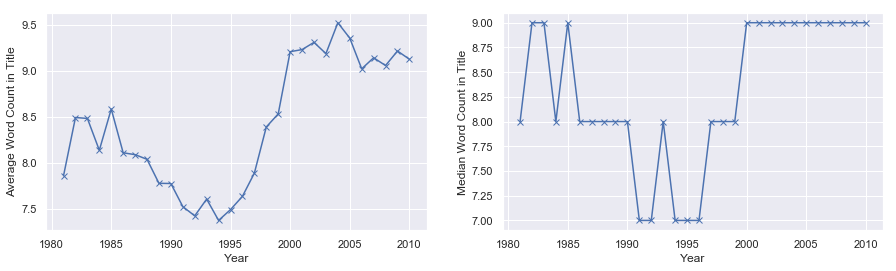

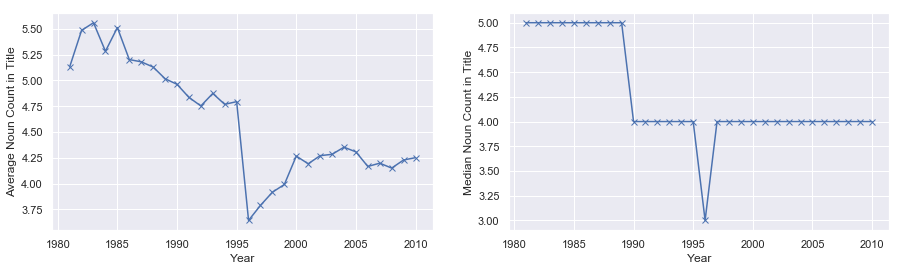

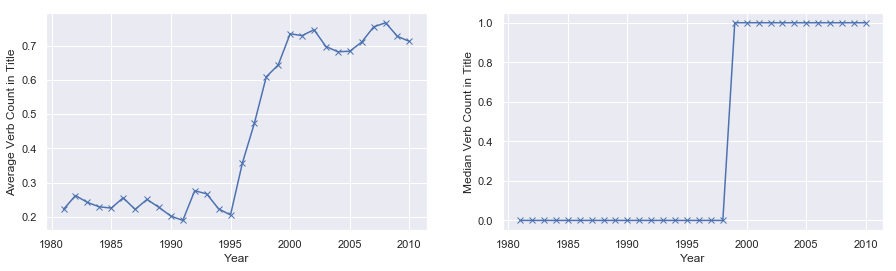

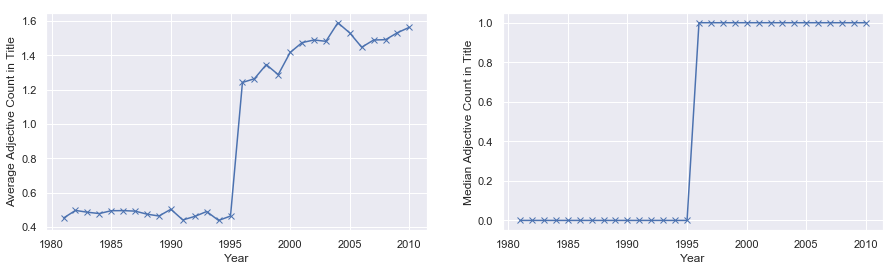

In [47]:
# Average Title Length and Median Title length over the years
average_word_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["length"].mean()
median_word_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["length"].median()

average_noun_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["noun_counts"].mean()
median_noun_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["noun_counts"].median()

average_verb_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["verb_counts"].mean()
median_verb_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["verb_counts"].median()

average_adj_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["adjective_counts"].mean()
median_adj_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["adjective_counts"].median()


f1 = plt.figure(figsize=(15,4))

ax1 = f1.add_subplot(121)
ax1.plot(average_word_count_groupedby_year['PubYear_x'], 
         average_word_count_groupedby_year['length'],
         marker="x")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Word Count in Title")


ax2 = f1.add_subplot(122)
ax2.plot(median_word_count_groupedby_year['PubYear_x'], 
         median_word_count_groupedby_year['length'],
         marker="x")
ax2.set_xlabel("Year")
ax2.set_ylabel("Median Word Count in Title")



f1 = plt.figure(figsize=(15,4))

ax3 = f1.add_subplot(121)
ax3.plot(average_noun_count_groupedby_year['PubYear_x'], 
         average_noun_count_groupedby_year['noun_counts'],
         marker="x")
ax3.set_xlabel("Year")
ax3.set_ylabel("Average Noun Count in Title")


ax4 = f1.add_subplot(122)
ax4.plot(median_noun_count_groupedby_year['PubYear_x'], 
         median_noun_count_groupedby_year['noun_counts'],
         marker="x")
ax4.set_xlabel("Year")
ax4.set_ylabel("Median Noun Count in Title")


f1 = plt.figure(figsize=(15,4))

ax5 = f1.add_subplot(121)
ax5.plot(average_verb_count_groupedby_year['PubYear_x'], 
         average_verb_count_groupedby_year['verb_counts'],
         marker="x")
ax5.set_xlabel("Year")
ax5.set_ylabel("Average Verb Count in Title")


ax6 = f1.add_subplot(122)
ax6.plot(median_verb_count_groupedby_year['PubYear_x'], 
         median_verb_count_groupedby_year['verb_counts'],
         marker="x")
ax6.set_xlabel("Year")
ax6.set_ylabel("Median Verb Count in Title")



f1 = plt.figure(figsize=(15,4))

ax7 = f1.add_subplot(121)
ax7.plot(average_adj_count_groupedby_year['PubYear_x'], 
         average_adj_count_groupedby_year['adjective_counts'],
         marker="x")
ax7.set_xlabel("Year")
ax7.set_ylabel("Average Adjective Count in Title")


ax8 = f1.add_subplot(122)
ax8.plot(median_adj_count_groupedby_year['PubYear_x'], 
         median_adj_count_groupedby_year['adjective_counts'],
         marker="x")
ax8.set_xlabel("Year")
ax8.set_ylabel("Median Adjective Count in Title")

In [49]:
data_pre95 = data[data.PubYear_x < 1998]
data_pre95.head()

,ArticleID,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,stanford_tagger_tags,tag_counts,verb_counts,noun_counts,adjective_counts,word_count,title_without_punct,log_c5,length
0,A1981MB41800038,1981,Article,INDEPENDENT CONTROL OF IMMUNOGLOBULIN HEAVY AND LIGHT CHAIN EXPRESSION IN A MURINE PRE-B-CELL LINE,NATURE,Nature,1981,23.0,"[(INDEPENDENT, NNP), (CONTROL, NNP), (OF, IN), (IMMUNOGLOBULIN, NNP), (HEAVY, JJ), (AND, NNP), (LIGHT, NNP), (CHAIN, NNP), (EXPRESSION, NNP), (IN, IN), (A, NNP), (MURINE, NNP), (PRE-B-CELL, NNP), (LINE, NNP)]","[0, 11, 1]",0,11,1,14,independent control of immunoglobulin heavy and light chain expression in a murine prebcell line,3.178054,14
1,A1981MK47400052,1981,Article,DEMETHYLATION OF CPG SITES IN DNA OF EARLY RABBIT TROPHOBLAST,NATURE,Nature,1981,14.0,"[(DEMETHYLATION, NNS), (OF, IN), (CPG, NN), (SITES, NNS), (IN, IN), (DNA, NN), (OF, IN), (EARLY, FW), (RABBIT, FW), (TROPHOBLAST, NN)]","[0, 5, 0]",0,5,0,10,demethylation of cpg sites in dna of early rabbit trophoblast,2.708050,10
5,000204440900038,1981,Article,Comb-layering in carbonatite dykes,NATURE,Nature,1981,5.0,"[(Comb-layering, JJ), (in, FW), (carbonatite, FW), (dykes, NNS)]","[0, 1, 1]",0,1,1,4,comblayering in carbonatite dykes,1.791759,4
8,A1981MT99400035,1981,Article,STRUCTURE SENSITIVITY IN THE IRON SINGLE-CRYSTAL CATALYZED SYNTHESIS OF AMMONIA,NATURE,Nature,1981,6.0,"[(STRUCTURE, NN), (SENSITIVITY, NN), (IN, IN), (THE, DT), (IRON, NNP), (SINGLE-CRYSTAL, NNP), (CATALYZED, NNP), (SYNTHESIS, NNP), (OF, IN), (AMMONIA, NNP)]","[0, 7, 0]",0,7,0,10,structure sensitivity in the iron singlecrystal catalyzed synthesis of ammonia,1.945910,10
9,A1981LS25500015,1981,Article,IR VARIABILITY OF SS433,NATURE,Nature,1981,4.0,"[(IR, NNP), (VARIABILITY, NNP), (OF, IN), (SS433, NN)]","[0, 3, 0]",0,3,0,4,ir variability of ss433,1.609438,4


Progress: 100%|██████████| 27337/27337 [00:00<00:00, 358256.67it/s]


(-0.5, 999.5, 499.5, -0.5)

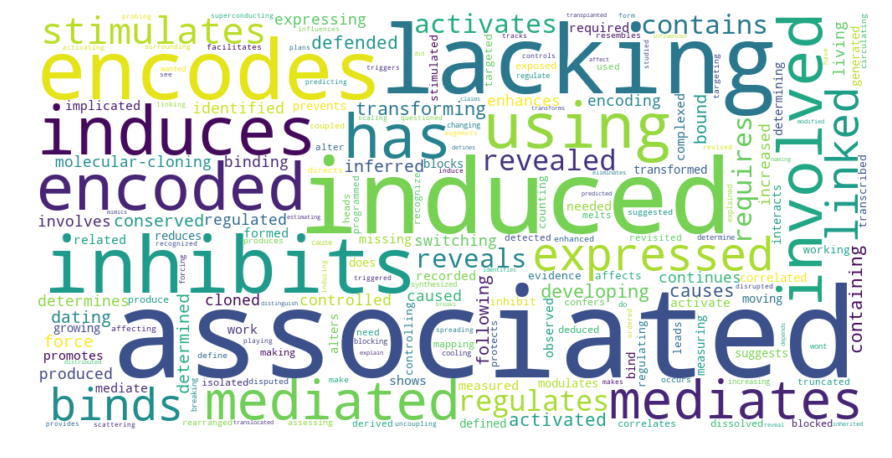

In [72]:
## What are the verbs which we used to see before 1995

data_pre95 = data[data.PubYear_x < 1998]

## Verbs with counts

verbs_list = []

def add_to_dict(tagged_pos):
    verbs_list.extend([word.lower() for (word, tag) in tagged_pos if tag in verb_tags])
   
data_pre95['stanford_tagger_tags'].progress_apply(lambda x: add_to_dict(x))

word_cloud_dict = Counter(verbs_list)
word_cloud_dict.pop('is', None)
word_cloud_dict.pop('are', None)
word_cloud_dict.pop('be', None)

wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [73]:
word_could_dict.most_common()

[('is', 866),
 ('are', 275),
 ('associated', 114),
 ('be', 77),
 ('induced', 76),
 ('lacking', 63),
 ('encodes', 62),
 ('inhibits', 61),
 ('induces', 51),
 ('encoded', 50),
 ('using', 48),
 ('involved', 45),
 ('has', 44),
 ('mediated', 44),
 ('mediates', 42),
 ('expressed', 41),
 ('binds', 39),
 ('linked', 37),
 ('stimulates', 36),
 ('regulates', 35),
 ('revealed', 35),
 ('activates', 34),
 ('requires', 34),
 ('contains', 33),
 ('reveals', 31),
 ('transforming', 30),
 ('developing', 30),
 ('causes', 28),
 ('containing', 28),
 ('activated', 27),
 ('defended', 27),
 ('conserved', 25),
 ('force', 25),
 ('dating', 25),
 ('bound', 25),
 ('following', 24),
 ('determined', 24),
 ('inferred', 23),
 ('molecular-cloning', 21),
 ('identified', 21),
 ('living', 21),
 ('regulated', 21),
 ('expressing', 21),
 ('encoding', 21),
 ('produced', 20),
 ('controlled', 20),
 ('enhances', 20),
 ('increased', 20),
 ('switching', 20),
 ('cloned', 20),
 ('binding', 19),
 ('caused', 19),
 ('continues', 19),
 ('d

Progress: 100%|██████████| 16295/16295 [00:00<00:00, 325462.67it/s]


(-0.5, 999.5, 499.5, -0.5)

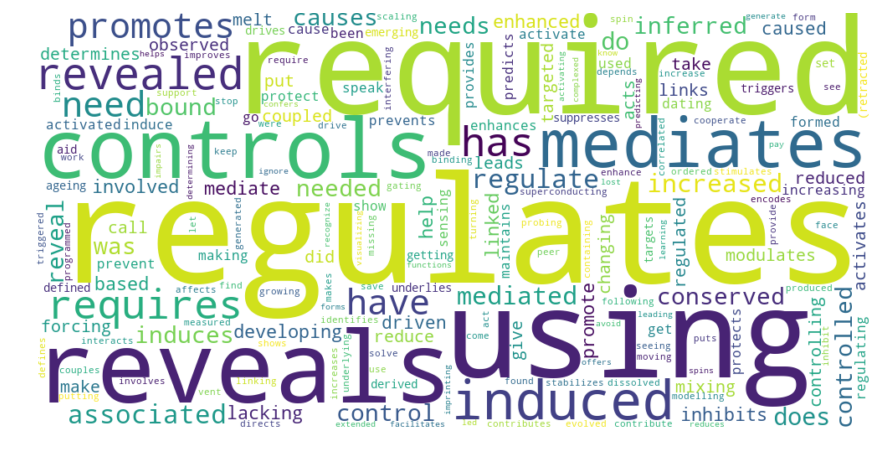

In [74]:

data_post95 = data[data.PubYear_x >= 1998]

## Verbs with counts

verbs_list = []

def add_to_dict(tagged_pos):
    verbs_list.extend([word.lower() for (word, tag) in tagged_pos if tag in verb_tags])
   
data_post95['stanford_tagger_tags'].progress_apply(lambda x: add_to_dict(x))

word_cloud_dict = Counter(verbs_list)
word_cloud_dict.pop('is', None)
word_cloud_dict.pop('are', None)
word_cloud_dict.pop('be', None)

wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [67]:
word_could_dict.most_common()

[('is', 867),
 ('are', 255),
 ('be', 188),
 ('regulates', 164),
 ('required', 145),
 ('using', 141),
 ('reveals', 107),
 ('controls', 99),
 ('mediates', 79),
 ('induced', 73),
 ('revealed', 73),
 ('requires', 65),
 ('has', 65),
 ('promotes', 65),
 ('have', 64),
 ('need', 63),
 ('regulate', 58),
 ('associated', 53),
 ('increased', 48),
 ('mediated', 47),
 ('do', 45),
 ('does', 45),
 ('controlled', 43),
 ('needs', 43),
 ('induces', 42),
 ('control', 42),
 ('inferred', 42),
 ('reveal', 41),
 ('bound', 41),
 ('causes', 41),
 ('conserved', 40),
 ('needed', 40),
 ('was', 39),
 ('developing', 38),
 ('based', 38),
 ('involved', 37),
 ('inhibits', 37),
 ('mediate', 36),
 ('linked', 35),
 ('lacking', 34),
 ('help', 34),
 ('promote', 34),
 ('enhanced', 34),
 ('driven', 32),
 ('caused', 32),
 ('reduced', 30),
 ('modulates', 30),
 ('forcing', 30),
 ('controlling', 29),
 ('determines', 29),
 ('make', 28),
 ('regulated', 27),
 ('coupled', 26),
 ('links', 26),
 ('reduce', 26),
 ('take', 25),
 ('acts',

Text(0.5,1,'2009')

<Figure size 432x288 with 0 Axes>

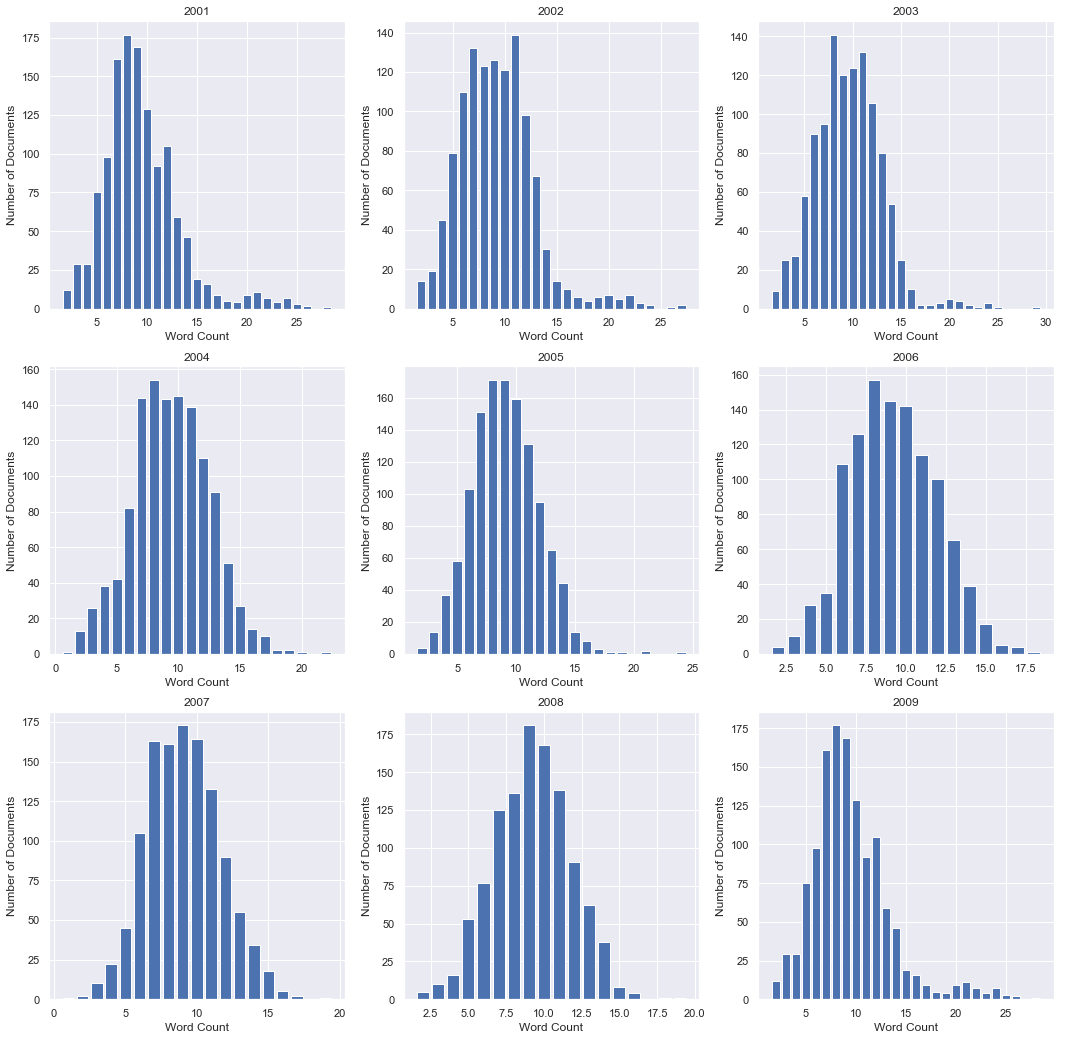

In [48]:
data_Yearwise = [data[data.PubYear_x == year] for year in range(2002, 2011)]

# Average character, word and cleaned title word counts over the years
f1 = plt.figure()
f1 = plt.figure(figsize=(18,18))


ax1 = f1.add_subplot(331)
_tmp = data_Yearwise[0]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2001")

ax1 = f1.add_subplot(332)
_tmp = data_Yearwise[1]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2002")


ax1 = f1.add_subplot(333)
_tmp = data_Yearwise[2]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2003")


ax1 = f1.add_subplot(334)
_tmp = data_Yearwise[3]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2004")


ax1 = f1.add_subplot(335)
_tmp = data_Yearwise[4]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2005")


ax1 = f1.add_subplot(336)
_tmp = data_Yearwise[5]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2006")


ax1 = f1.add_subplot(337)
_tmp = data_Yearwise[6]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2007")


ax1 = f1.add_subplot(338)
_tmp = data_Yearwise[7]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2008")


ax1 = f1.add_subplot(339)
_tmp = data_Yearwise[0]
tmp = _tmp.groupby('word_count').size().reset_index(name="count")
ax1.bar(tmp['word_count'], 
         tmp['count'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Number of Documents")
ax1.set_title("2009")
